In [1]:
# Ref: https://blog.keras.io/building-autoencoders-in-tf.keras.html

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf

In [3]:
input_img = tf.keras.Input(shape=(28, 28, 1), name='input_img')

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation=None, padding='same')(x) # omit sigmoid activation at the end

autoencoder = tf.keras.Model(input_img, decoded)

In [4]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

In [5]:
# build decoder

encoded_input = tf.keras.Input(shape=(4, 4, 8), name='encoded_input')
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_input)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation=None, padding='same')(x) # omit sigmoid activation at the end

decoder = tf.keras.Model(encoded_input, decoded)

In [6]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoded_input (InputLayer)  [(None, 4, 4, 8)]         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 8)           584       
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 16)        1168

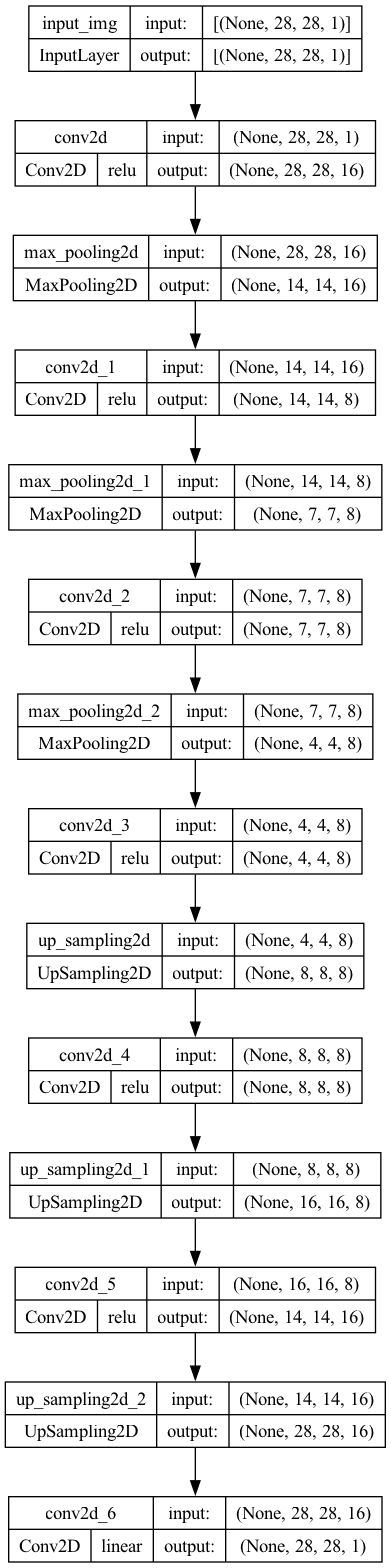

In [7]:
from tensorflow.keras.utils import plot_model

# plot model and display image
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_activations=True)
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True, show_layer_activations=True)

In [8]:
# iterate over the layers and export models from first to current layer to h5 files
for i in range(1, len(autoencoder.layers)):
    model_i = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[i].output, name=f"autoencoder_{i}")
    model_i.save(f"autoencoder_{i}/model.h5")

/root/oppai-models/oppai/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
for i in range(1, len(decoder.layers)):
    model_i = tf.keras.Model(inputs=decoder.inputs, outputs=decoder.layers[i].output, name=f"decoder_{i}")
    model_i.save(f"decoder_{i}/model.h5")

In [10]:
import tf2onnx

spec = tf.TensorSpec([1, 28, 28, 1], tf.float32, name='input_img')

for i in range(1, len(autoencoder.layers)):
    model_i = tf.keras.models.load_model(f'autoencoder_{i}/model.h5')
    tf2onnx.convert.from_keras(
        model_i,
        input_signature=[spec],
        inputs_as_nchw=['input_img'],
        opset=18,
        output_path=f'autoencoder_{i}/model.onnx'
    )

In [11]:
spec = tf.TensorSpec([1, 4, 4, 8], tf.float32, name='encoded_input')

for i in range(1, len(decoder.layers)):
    model_i = tf.keras.models.load_model(f'decoder_{i}/model.h5')
    tf2onnx.convert.from_keras(
        model_i,
        input_signature=[spec],
        inputs_as_nchw=['encoded_input'],
        opset=18,
        output_path=f'decoder_{i}/model.onnx'
    )

In [12]:
import sys
sys.path.append('..')
from keras2circom.keras2circom import circom, transpiler
circom.dir_parse('../keras2circom/node_modules/circomlib-ml/circuits/', skips=['util.circom', 'circomlib-matrix', 'circomlib', 'crypto'])

In [13]:
for i in range(1, len(autoencoder.layers)):
    args = {
        '<model.h5>': f'autoencoder_{i}/model.h5',
        '--output': f'autoencoder_{i}',
        '--raw': False,
        '--decimals': "18"
    }
    transpiler.transpile(args['<model.h5>'], args['--output'], args['--raw'], args['--decimals'])

In [14]:
for i in range(1, len(decoder.layers)):
    args = {
        '<model.h5>': f'decoder_{i}/model.h5',
        '--output': f'decoder_{i}',
        '--raw': False,
        '--decimals': "18"
    }
    transpiler.transpile(args['<model.h5>'], args['--output'], args['--raw'], args['--decimals'])

In [15]:
import subprocess

commands = []

for i in range(1, len(decoder.layers)):
    commands.append(['circom', f'decoder_{i}/circuit.circom', '--O0', '--r1cs', '-o', f'decoder_{i}'])

# Run each command sequentially and print their output
for cmd in commands:
    subprocess.call(cmd)

template instances: 12
non-linear constraints: 75392
linear constraints: 108848
public inputs: 0
private inputs: 1096
public outputs: 128
wires: 184825
labels: 184825
Written successfully: decoder_1/circuit.r1cs
Everything went okay
template instances: 13
non-linear constraints: 75392
linear constraints: 110384
public inputs: 0
private inputs: 1608
public outputs: 512
wires: 186361
labels: 186361
Written successfully: decoder_2/circuit.r1cs
Everything went okay
template instances: 15
non-linear constraints: 376960
linear constraints: 541408
public inputs: 0
private inputs: 3728
public outputs: 512
wires: 919025
labels: 919025
Written successfully: decoder_3/circuit.r1cs
Everything went okay
template instances: 16
non-linear constraints: 376960
linear constraints: 547552
public inputs: 0
private inputs: 5776
public outputs: 2048
wires: 925169
labels: 925169
Written successfully: decoder_4/circuit.r1cs
Everything went okay
template instances: 17
non-linear constraints: 2224064
linear con

In [16]:
import subprocess

commands = []

for i in range(1, len(autoencoder.layers)):
    commands.append(['circom', f'autoencoder_{i}/circuit.circom', '--O0', '--r1cs', '-o', f'autoencoder_{i}'])

# Run each command sequentially and print their output
for cmd in commands:
    subprocess.call(cmd)

template instances: 12
non-linear constraints: 6598144
linear constraints: 7089364
public inputs: 0
private inputs: 38576
public outputs: 12544
wires: 13675909
labels: 13675909
Written successfully: autoencoder_1/circuit.r1cs
Everything went okay
template instances: 19
non-linear constraints: 9784320
linear constraints: 7308884
public inputs: 0
private inputs: 41712
public outputs: 3136
wires: 17069061
labels: 17069061
Written successfully: autoencoder_2/circuit.r1cs
Everything went okay
template instances: 22
non-linear constraints: 10820768
linear constraints: 9118500
public inputs: 0
private inputs: 47576
public outputs: 1568
wires: 19914717
labels: 19914717
Written successfully: autoencoder_3/circuit.r1cs
Everything went okay
template instances: 24
non-linear constraints: 11219040
linear constraints: 9145940
public inputs: 0
private inputs: 47968
public outputs: 392
wires: 20338861
labels: 20338861
Written successfully: autoencoder_4/circuit.r1cs
Everything went okay
template insta